# Critical Days of Low Flow
## The algorithm
This function identifies periods of consecutively low river discharge and classifies them into different severity categories based on duration. It takes a discharge time series as input and checks how many consecutive days the flow stays below a critical threshold (e.g. 500 m³/s). Depending on the number of days, it assigns one of three severity labels:

Caution: 1–3 consecutive days below threshold

Risk: 4–7 consecutive days

Critical: More than 7 consecutive days

This classification allows for identifying not only isolated low-flow events but also escalating hydrological stress periods. These severity classes are visualized using colored segments in a plot (yellow for caution, orange for risk, and red for critical). The method provides intuitive insight into how prolonged low flows may threaten ecological continuity, for instance for fish migration.
This file is created to store the function so it doesn't have to be written out in other files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nbformat

# Sample discharge data with low-flow sequences
discharge_data = [ 624, 1442, 2035, 632, 1143, 433, 455, 467, 1672, 917, 1955, 1258, 1398, 1130, 817, 489, 473, 437, 482, 467, 454, 1295, 1219, 1619, 1191, 1576, 1053, 1440, 1800, 1344, 962, 897, 700, 1467, 781, 1936, 1821, 1224, 1368, 2014, 486, 470, 450, 473, 469, 499, 451, 493, 480, 492, 445, 756, 1959, 805, 685, 1288, 659, 699, 1430, 1447 ]
days = list(range(1, len(discharge_data) + 1))
dates = pd.date_range(start="2020-01-01", periods=len(discharge_data))
discharge_series = pd.Series(discharge_data, index=dates)

To determine the discharge statusses a function is computed. The output is a binary array: 1 indicates the flow is above the threshold, 0 indicates it is at or below the threshold. This classification step simplifies the identification of critical periods.

In [2]:
def classify_discharge_status(discharge_values):
    statuses = []
    consecutive_low_days = 0

    for value in discharge_values:
        if value < 500:
            consecutive_low_days += 1
            if 1 <= consecutive_low_days <= 3:
                status = "caution"
            elif 4 <= consecutive_low_days <= 7:
                status = "risk"
            else:
                status = "critical"
        else:
            consecutive_low_days = 0
            status = "normal"
        statuses.append(status)

    return statuses

To isolate continuous periods of similar flow behavior, a segmentation function is computed. It groups the time series into segments where the flow remains consistently above or below the threshold. Each segment is labeled with a color.

In [8]:
def get_segments_final_color_safe(x, y, threshold=500):
    segments = []
    colors = []
    low_flow_counter = 0
    tracking_low_flow = False

    for i in range(len(x) - 1):
        xi = [x[i], x[i + 1]]
        yi = [y[i], y[i + 1]]

        if y[i] < threshold:
            if not tracking_low_flow:
                low_flow_counter = 1
                tracking_low_flow = True
            else:
                low_flow_counter += 1
        elif tracking_low_flow and y[i + 1] < threshold:
            low_flow_counter += 1
        else:
            tracking_low_flow = False
            low_flow_counter = 0

        # kleur alléén als beide punten onder threshold zijn
        if y[i] < threshold and y[i + 1] < threshold:
            if 1 <= low_flow_counter <= 3:
                color = 'yellow'
            elif 4 <= low_flow_counter <= 7:
                color = 'orange'
            else:
                color = 'red'
        else:
            color = 'black'

        segments.append((xi, yi))
        colors.append(color)

    return segments, colors

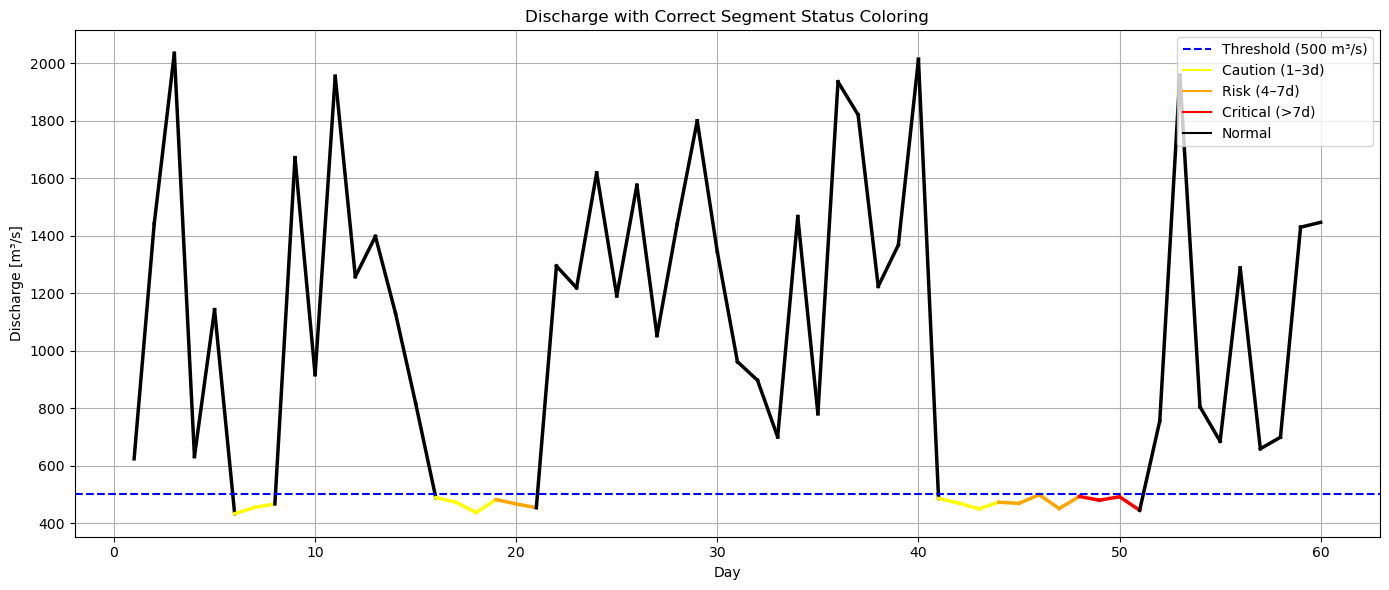

In [4]:
segments, segment_colors = get_segments_final_color_safe(days, discharge_data)


plt.figure(figsize=(14, 6))
for (x_seg, y_seg), color in zip(segments, segment_colors):
    plt.plot(x_seg, y_seg, color=color, linewidth=2.5)

plt.axhline(500, color='blue', linestyle='--', label='Threshold (500 m³/s)')
plt.plot([], [], color='yellow', label='Caution (1–3d)')
plt.plot([], [], color='orange', label='Risk (4–7d)')
plt.plot([], [], color='red', label='Critical (>7d)')
plt.plot([], [], color='black', label='Normal')
plt.legend()

plt.xlabel("Day")
plt.ylabel("Discharge [m³/s]")
plt.title("Discharge with Correct Segment Status Coloring")
plt.grid(True)
plt.tight_layout()
plt.show()

## Droughts function
The droughts() function is used in calibration to extract event-based metrics such as drought duration and cumulative deficit from both observed and simulated discharge data. This enables the calibration process to explicitly target low-flow conditions, which are often underrepresented in traditional performance metrics. By comparing these extracted drought characteristics—using distribution-based metrics like Earth Mover’s Distance—the model is tuned to more accurately reproduce the timing and severity of drought events, thereby improving its suitability for drought impact assessments and water resource management.

In [5]:
def droughts(df, basin_name, q_crit=500):
    drought_list = []
    drought_id = 1
    idx = 0

    # Handle empty input early
    if df is None or len(df) == 0:
        drought_list.append({
            "Drought Number": 0,
            "Start Date": None,
            "Duration (days)": 0,
            "Max Cumulative Deficit (m3/s)": 0,
            "Cum Deficit List": [],
            "Basin": basin_name
        })
        return pd.DataFrame(drought_list)

    while idx < len(df):
        if df.iloc[idx] <= q_crit:
            start = df.index[idx]
            cum_def = 0
            max_deficit = 0
            cum_deficits = []
            duration = 0

            # Collect consecutive low-flow days
            while idx < len(df) and df.iloc[idx] <= q_crit:
                daily_deficit = df.iloc[idx] - q_crit
                cum_def += daily_deficit
                max_deficit = min(max_deficit, cum_def)
                cum_deficits.append(cum_def)
                duration += 1
                idx += 1

            if max_deficit < 0:
                drought_list.append({
                    "Drought Number": drought_id,
                    "Start Date": start,
                    "Duration (days)": duration,
                    "Max Cumulative Deficit (m3/s)": max_deficit,
                    "Cum Deficit List": cum_deficits,
                    "Basin": basin_name
                })
                drought_id += 1
        else:
            idx += 1

    # If no droughts found, return a neutral row
    if len(drought_list) == 0:
        drought_list.append({
            "Drought Number": 0,
            "Start Date": df.index[0] if len(df.index) > 0 else None,
            "Duration (days)": 0,
            "Max Cumulative Deficit (m3/s)": 0,
            "Cum Deficit List": [],
            "Basin": basin_name
        })

    return pd.DataFrame(drought_list)

In [6]:
result_df = droughts(discharge_series, basin_name="TestBasin", q_crit=500)
result_df.head()

,Drought Number,Start Date,Duration (days),Max Cumulative Deficit (m3/s),Cum Deficit List,Basin
0,1,2020-01-06,3,-145,"[-67, -112, -145]",TestBasin
1,2,2020-01-16,6,-198,"[-11, -38, -101, -119, -152, -198]",TestBasin
2,3,2020-02-10,11,-292,"[-14, -44, -94, -121, -152, -153, -202, -209, ...",TestBasin


## To .py module

In [7]:
def export_functions_from_notebook(ipynb_path, py_path):
    # Load the notebook
    with open(ipynb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    function_lines = []
    recording = False

    for cell in nb.cells:
        if cell.cell_type != "code":
            continue
        lines = cell.source.split('\n')
        for line in lines:
            if line.strip().startswith("def "):
                recording = True
            if recording:
                function_lines.append(line)
        # Add blank lines between functions
        if recording:
            function_lines.append("")  # one empty line
            recording = False

    # Write to .py file
    with open(py_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(function_lines))

    print(f"Exported functions to: {py_path}")

# Example usage
export_functions_from_notebook("CriticalDaysLowFlow.ipynb", "critical_days_module.py")

Exported functions to: critical_days_module.py
